<a href="https://colab.research.google.com/github/marongkang/MLeveryday/blob/main/MLEveryday13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#多层感知(MLP,Multilayer Perceptron)
使用PyTorch实现

#OverView
$z_2=XW_1$  
$a_2=f(z_2)$  
$z_3=a_2W_2$  
$\hat{y}=softmax(z_3)$

where:  
*  $X=输入|∈\mathbb{R}^{NXD}(D为特征数量)$)  
*  $W_1=第一层权重|∈\mathbb{R}^{DXH}(H是隐含层在第一层的单元数量)$  
*  $z_2=第一层权重的输出∈\mathbb{R}^{NXH}$  
*  $f=非线性激活函数$
*  $a_2=应用在第一层输出的激活值|∈\mathbb{R}^{NXD}$  
*  $W_2=第二层权重|\in\mathbb{R}^{HXC}(C为类别数量)$
*  $\hat{y}=预测|∈\mathbb{NXC}(N为采样数量)$

**MLP**
*  **目的**: 对于**非线性**数据输入,预测类别的概率  
*  **优势**:处理非线性模式
*  **劣势**:
 * 容易过拟合
 * 计算精度取决于网络体积
 * 可解释性差
*  多样性 

#Training

步骤:

1. 随机初始化模型权重$W$
2. 给予模型$X$算出概率
3. 比较预测值$\hat{y}$和真实值$y$,使用损失函数确定损失值$J$(此处使用的是交叉熵(Cross Entropy Loss)).
 *  $z_2=XW_1$  
 *  $a_2=max(0,z_2)$  
 *  $z_3=a_2W_2$  
 *  $\hat{y}=softmax(z_3)$
 *  $J(θ)=-∑_iy_iln(\hat{y_i})$ 
4. 计算损失$J(\theta)$w.r.t对模型权重的梯度
 *  $\frac{∂J}{∂W_{2j}}=a_2\hat{y},\frac{∂J}{∂W_{2y}}=a_2(\hat{y}-1)$
 *  $\frac{∂J}{∂W_1}=\frac{∂J}{∂\hat{y}}\frac{∂\hat{y}}{∂a_2}\frac{∂a_2}{∂z_2}\frac{∂z_2}{∂W_1}=W_2(∂scores)(∂ReLU)X$ 
5. 应用反向传播法(backpropagation)到梯度下降更新权重$W$.这些更新减少错误类别的概率,增加正确类别的概率
 * $W_i=W_i-\alpha\frac{∂J}{∂W_i}$
6. 重复2-4,直到模型收敛

#数据

In [ ]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
#from d2l import torch as d2l
from argparse import  Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm_notebook

#d2l.use_svg_display()

c:\users\24987\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Arguments
args = Namespace(
  seed=123,
  num_samples_per_class=500,
  dimensions=2,
  num_classes=3,
  train_size=0.75,
  test_size=0.25,
  num_hidden_units=100,
  learning_rate=1e-0,
  regularization=1e-3,
  num_epochs=200,
)
np.random.seed(args.seed)

In [ ]:
def generate_data(num_samples_per_class,dimensions,num_classes):
  X_origin=np.zeros((num_samples_per_class*num_classes,dimensions))
  y=np.zeros(num_samples_per_class*num_classes,dtype='uint8')
  for j in range(num_classes):
    ix=range(num_samples_per_class*j,num_samples_per_class*(j+1))
    r=np.linspace(0.0,1,num_samples_per_class)
    t=np.linspace(j*4,(j+1)*4,num_samples_per_class)+np.random.randn(num_samples_per_class)*0.2
    X_origin[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    y[ix]=j
  X=np.hstack([X_origin])

  return X,y

In [ ]:
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
            dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(X))
print ("y: {0}".format(np.shape(y)))

X: [[-0.00000000e+00  0.00000000e+00]
 [ 4.12824878e-04  1.96102620e-03]
 [ 2.90837400e-04  3.99744995e-03]
 ...
 [-5.54796456e-01  8.27164388e-01]
 [-4.58349743e-01  8.86516505e-01]
 [-2.14117896e-01  9.76807825e-01]]
y: (1500,)


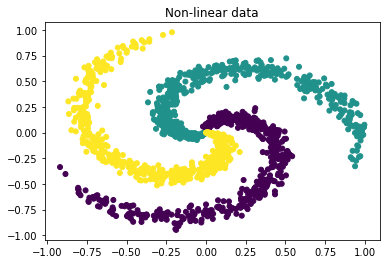

In [ ]:
#plt.figure(dpi=100)
plt.title("Non-linear data")
plt.scatter(X[:,0],X[:,1],c=y,s=25)
plt.show()

In [ ]:
#convert to tensor
X=torch.from_numpy(X).float()
y=torch.from_numpy(y).long()

In [ ]:
#shuffle
shuffle_indicies=torch.LongTensor(random.sample(range(0,len(X)),len(X)))
X=X[shuffle_indicies]
y=y[shuffle_indicies]

#split datasets
test_start_idx=int(len(X)*args.train_size)
X_train=X[:test_start_idx]
y_train=y[:test_start_idx]
X_test=X[test_start_idx:]
y_test=y[test_start_idx:]
print("train_size:{}\ntest_size:{}".format(len(X_train),len(X_test)))

train_size:1125
test_size:375


#使用线性模型强行拟合

In [ ]:
#logistic regression
class LogisticClassifier(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    super(LogisticClassifier,self).__init__()
    self.fc1=nn.Linear(input_dim,hidden_dim)
    self.fc2=nn.Linear(hidden_dim,output_dim)
  
  def forward(self,x_in,apply_softmax=False):
    a_1=self.fc1(x_in)
    y_pred=self.fc2(a_1)

    if apply_softmax:
      y_pred=F.softmax(y_pred,dim=1)
    return y_pred

In [ ]:
model=LogisticClassifier(input_dim=args.dimensions,
             hidden_dim=args.num_hidden_units,
             output_dim=args.num_classes)
model.named_modules

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>

In [ ]:
#根据损失函数优化optimization
Loss_fun=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=args.learning_rate)#Adam optimizer 一般优于SGD

In [ ]:
#accuracy
def get_accuracy(y_pred,y_target):
  n_correct=torch.eq(y_pred,y_target).sum().item()
  accuracy=n_correct/len(y_pred)*100
  return accuracy

In [ ]:
#训练
for epoch in range(args.num_epochs):
  y_pred=model(X_train)
  _,pred=y_pred.max(dim=1)
  accuracy=get_accuracy(pred.long(),y_train)

  loss=Loss_fun(y_pred,y_train)
  
  print("epoch:",epoch,"loss:",loss,"acc:",accuracy)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()



epoch: 0 loss: tensor(1.1284, grad_fn=<NllLossBackward0>) acc: 29.955555555555556
epoch: 1 loss: tensor(6.6418, grad_fn=<NllLossBackward0>) acc: 52.71111111111111
epoch: 2 loss: tensor(159.5362, grad_fn=<NllLossBackward0>) acc: 33.68888888888889
epoch: 3 loss: tensor(50.3483, grad_fn=<NllLossBackward0>) acc: 37.6
epoch: 4 loss: tensor(16.8540, grad_fn=<NllLossBackward0>) acc: 59.37777777777777
epoch: 5 loss: tensor(30.2219, grad_fn=<NllLossBackward0>) acc: 50.75555555555555
epoch: 6 loss: tensor(13.5969, grad_fn=<NllLossBackward0>) acc: 51.288888888888884
epoch: 7 loss: tensor(52.8424, grad_fn=<NllLossBackward0>) acc: 33.51111111111111
epoch: 8 loss: tensor(25.1659, grad_fn=<NllLossBackward0>) acc: 59.73333333333334
epoch: 9 loss: tensor(25.3513, grad_fn=<NllLossBackward0>) acc: 60.62222222222222
epoch: 10 loss: tensor(30.6418, grad_fn=<NllLossBackward0>) acc: 60.88888888888889
epoch: 11 loss: tensor(28.1367, grad_fn=<NllLossBackward0>) acc: 62.93333333333333
epoch: 12 loss: tensor(22.

In [ ]:
_,pred_train=model(X_train,apply_softmax=True).max(dim=1)
_,pred_test=model(X_test,apply_softmax=True).max(dim=1)

In [ ]:
train_acc=get_accuracy(pred_train,y_train)
test_acc=get_accuracy(pred_test,y_test)
print("test_acc:",test_acc,"train_acc",train_acc)

test_acc: 53.06666666666666 train_acc 52.97777777777778


In [ ]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    #将(x_min,y_min)(x_max,y_max)之间划分为101*101的网格
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    #将(xx,yy)作为一个输入
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    #使用训练好的模型预测y
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)

    #画出等高线图
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    #散点图
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

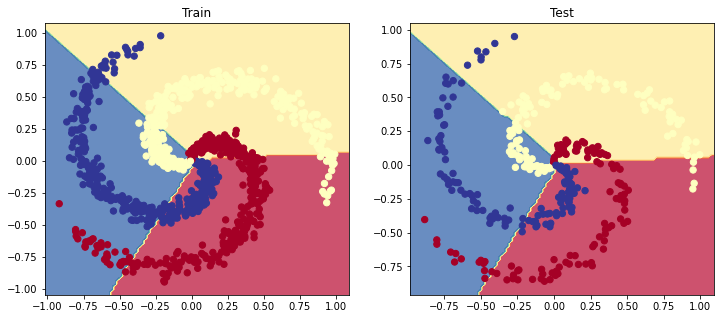

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

#confusion matrix

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       119
           1       0.63      0.59      0.61       135
           2       0.46      0.48      0.47       121

    accuracy                           0.53       375
   macro avg       0.53      0.53      0.53       375
weighted avg       0.53      0.53      0.53       375



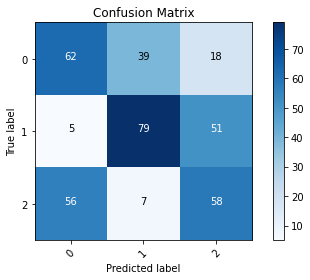

In [ ]:
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

#使用MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(MLP,self).__init__()
        self.fc1=nn.Linear(input_dim,hidden_dim)
        self.fc2=nn.Linear(hidden_dim,output_dim)

    def forward(self,x_input,apply_softmax=False):
        a_1=F.relu(self.fc1(x_input))
        y_pred=self.fc2(a_1)

        if apply_softmax:
            y_pred=F.softmax(y_pred,dim=1)

        return y_pred

In [ ]:
#initialize
mlp_model=MLP(
    input_dim=args.dimensions,
    hidden_dim=args.num_hidden_units,
    output_dim=args.num_classes)
print(mlp_model)

MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(mlp_model.parameters(),lr=args.learning_rate)

In [ ]:
for epoch in range(args.num_epochs):
    y_pred=mlp_model(X_train)
    _,predictions=y_pred.max(dim=1)
    acc=get_accuracy(predictions,y_train)

    loss=loss_fn(y_pred,y_train)

    if epoch%20==0:
        print("loss:",loss,"acc:",acc)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

loss: tensor(0.0076, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0075, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0073, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0072, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0071, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0070, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0069, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0068, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0067, grad_fn=<NllLossBackward0>) acc: 99.82222222222222
loss: tensor(0.0066, grad_fn=<NllLossBackward0>) acc: 99.82222222222222


In [ ]:
# Predictions
_, pred_train = mlp_model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = mlp_model(X_test, apply_softmax=True).max(dim=1)

In [ ]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.7%, test acc: 100.0%


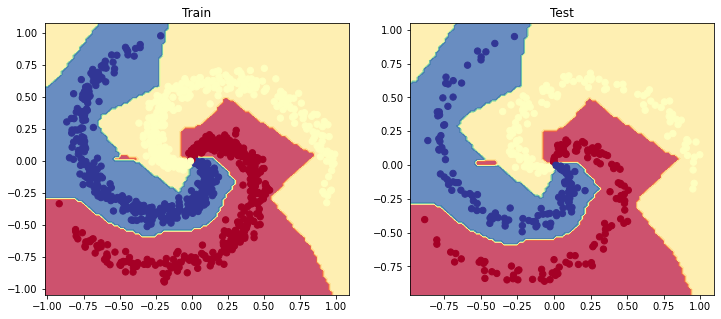

In [ ]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=mlp_model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=mlp_model, X=X_test, y=y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       119
           1       0.97      0.97      0.97       135
           2       1.00      0.96      0.98       121

    accuracy                           0.97       375
   macro avg       0.97      0.97      0.97       375
weighted avg       0.97      0.97      0.97       375



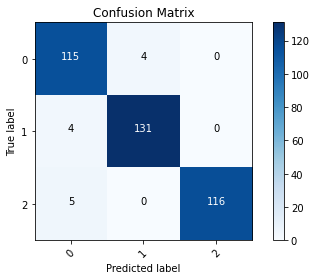

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))